
# AIctive assignment
En esta actividad se busca completar usando la variable **Global active power** las siguientes actividades:
* Calcular el promedio diario.
* Grafíquela.
* Observe que en una misma época de cada año hay un mínimo. ¿Cuál es dicha época del año? (dejando fuera los mínimos puntuales producidos por el ruido).
* Implemente una función que encuentre dicho mínimo para cada año, dejando fuera el ruido.
* Implemente una función que prediga el valor del promedio diario de dicha variable para cada día del año 2011.
* Grafique dichas predicciones.
* Calcule las componentes de frecuencia más relevantes en la serie de tiempo.

### **1. Preparación**


#### Importar librerías y datos necesarios

In [363]:
# Importar librerías 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother, KalmanSmoother
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tsmoothie.utils_func import sim_seasonal_data
from tsmoothie.smoother import DecomposeSmoother
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft, fftfreq, fftshift

## for Deep-learing:

from prophet import Prophet


In [364]:
# Importar datos
df = pd.read_csv('household_power_consumption.txt', sep=';',
                  parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'],index_col='dt')

#### Análisis exploratorio y transformación de datos.
Se realiza un breve análisis exploratorio de los datos y las transformaciones necesarias.
* Forma.
* Inspección de datos.
* Número de valores faltantes.
* Exploración de fecha: rango de fecha y número de datos por año.
* Revisar si estan equiespaciados.
* Exploración global active power: máximos y mínimos.

In [365]:
# Forma del Dataframe a utilizar
df.shape

(2075259, 7)

In [366]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [367]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [368]:
# Checkeo de valores faltantes.
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

#### Transformaciones

In [369]:
# Creación de columna Datetime
df['Date'] = df.index.date
df['time'] = df.index.time
df['Date'] = df['Date'].astype(str)
df['time'] = df['time'].astype(str)
# Convertir a formato DateTime 
df['exact_time'] = df['Date']+";"+df['time']
df['exact_time_DT'] = pd.to_datetime(df['exact_time'],format="%Y-%m-%d;%H:%M:%S")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Date                   object        
 8   time                   object        
 9   exact_time             object        
 10  exact_time_DT          datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 190.0+ MB


In [370]:
# Sacar columnas que no se utilizan y consevar solo columna DateTime y variable objetivo
data = df.drop(['Date', 'time','exact_time','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'],axis = 1).sort_values(by=['exact_time_DT'])
data.head(10)

,Global_active_power,exact_time_DT
dt,,
2006-12-16 17:24:00,4.216,2006-12-16 17:24:00
2006-12-16 17:25:00,5.360,2006-12-16 17:25:00
2006-12-16 17:26:00,5.374,2006-12-16 17:26:00
2006-12-16 17:27:00,5.388,2006-12-16 17:27:00
2006-12-16 17:28:00,3.666,2006-12-16 17:28:00
2006-12-16 17:29:00,3.520,2006-12-16 17:29:00
2006-12-16 17:30:00,3.702,2006-12-16 17:30:00
2006-12-16 17:31:00,3.700,2006-12-16 17:31:00
2006-12-16 17:32:00,3.668,2006-12-16 17:32:00


In [371]:
# Número de datos por año
data[['Global_active_power']].groupby(data.index.year).count()

,Global_active_power
dt,
2006,21992
2007,521669
2008,526905
2009,521320
2010,457394


Dado que el número de datos para el 2016 no es suficiente para interpretar al año completo, se descartan los datos de este año para el resto de la actividad.

In [372]:
# Modificar dataframe para años posteriores al 2006
data=data[data.index.year>2006]

Frente al número de valores faltantes, estos se rellenan con valores generados.

In [373]:
# Reemplazar los valores faltantes
gap=data.fillna(axis=0,method='ffill')

### **2. Promedio diario**
Es importante destacar que se puede entender el promedio diario de dos formas:
1. El promedio del total consumido por dia.
2. El promedio de los puntos dentro de un mismo dia.

#### Promedio diario: Forma 1
$$ \textup{promedio diario}=\frac{\sum_{i=1}^n \textup{Global active power}_i}{\textup{N° de dias}} $$

In [374]:
gap.head()

,Global_active_power,exact_time_DT
dt,,
2007-01-01 00:00:00,2.580,2007-01-01 00:00:00
2007-01-01 00:01:00,2.552,2007-01-01 00:01:00
2007-01-01 00:02:00,2.550,2007-01-01 00:02:00
2007-01-01 00:03:00,2.550,2007-01-01 00:03:00
2007-01-01 00:04:00,2.554,2007-01-01 00:04:00


In [375]:
# Calculo de consumo diario.
consumo_diario=gap.groupby(gap.index.date).sum()
consumo_diario.index = pd.to_datetime(consumo_diario.index)
consumo_diario.head()

,Global_active_power
2007-01-01,2749.004
2007-01-02,1269.236
2007-01-03,1014.054
2007-01-04,3259.412
2007-01-05,2713.364


In [376]:
# Calculo de consumo diario promedio.
day_avg=consumo_diario.mean()[0]
print('Consumo promedio diario: ', day_avg)

Consumo promedio diario:  1551.3705764375875


#### Promedio diario: Forma 2
$$ \textup{promedio diario}=\frac{\sum_{i=1}^n \textup{Global active power}_i}{\textup{N° de puntos en un dia}} $$

In [377]:
# Calculo de promedio diario para todas las fechas
promedio_diario=gap.groupby(gap.index.date).mean()
promedio_diario.index = pd.to_datetime(promedio_diario.index)
promedio_diario.head()

,Global_active_power
2007-01-01,1.909031
2007-01-02,0.881414
2007-01-03,0.704204
2007-01-04,2.263481
2007-01-05,1.884281


In [378]:
# Promedio diario
daily_avg=promedio_diario.mean()[0]
print('Consumo promedio diario: ', daily_avg)

Consumo promedio diario:  1.077442237728558


### **3. Gráficos Global active power** 

Se parte graficando el global active power.

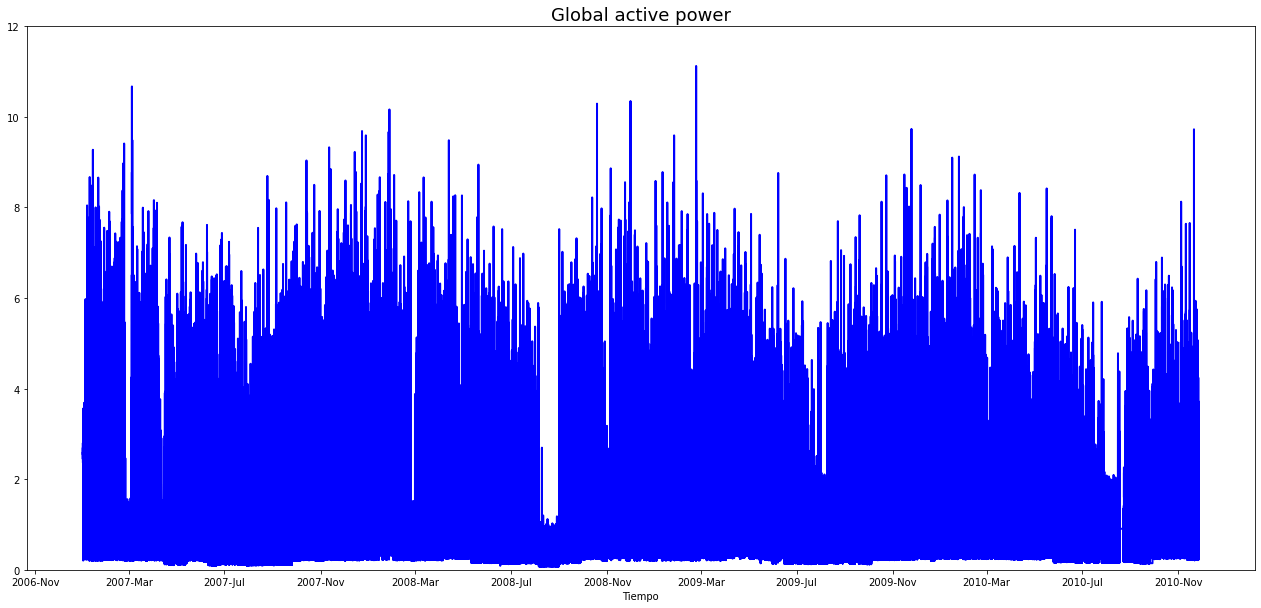

In [379]:
dtFmt = mdates.DateFormatter('%Y-%b') # Definir formato de fecha
plt.figure(figsize=(22,10))
plt.plot(gap['Global_active_power'], linewidth=2, color='blue')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.title("Global active power", fontsize=18)
plt.ylim((0,12))
plt.xlabel('Tiempo')
plt.show()

Frente a que el gráfico anterior no entrega mucha información, se grafican los promedios diarios.

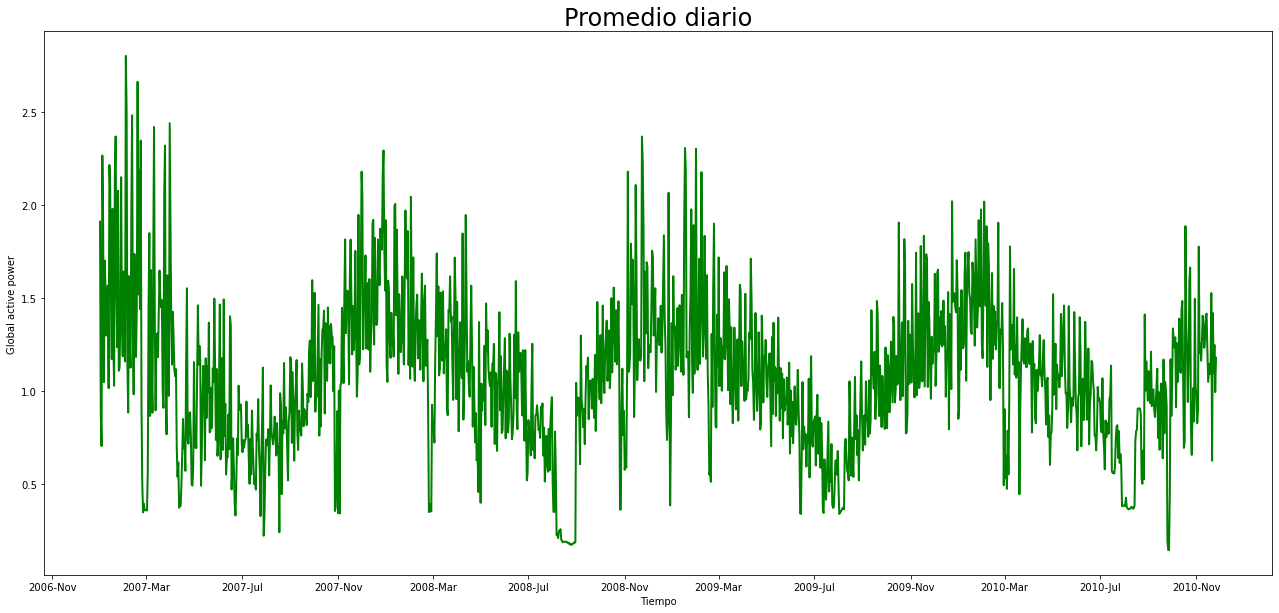

In [380]:
plt.figure(figsize=(22,10))
plt.plot(promedio_diario['Global_active_power'], linewidth=2, color='green')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) # Cada cuatro meses aparece la etiqueta del eje horizontal
plt.title("Promedio diario", fontsize=24)
plt.xlabel('Tiempo')
plt.ylabel('Global active power')
plt.show()

### **4. Época del año donde ocurre un mínimo(descontando los puntos ocasionados por ruido)** 
Dado que no tiene sentido explorar en que época del año existe un mínimo de global active power para una hora en específico, se toma al promedio diario como variable objetivo en la siguiente actividad. 

Más específicamente, esta sección se toma como la búsqueda de una época en la que tienden a estar los mínimos a lo largo de los años. Para esto, se observara el comportamiento de los datos sin modificarlos y de ser necesario se suavizara la curva para determinar la época objetivo.

#### Inspección

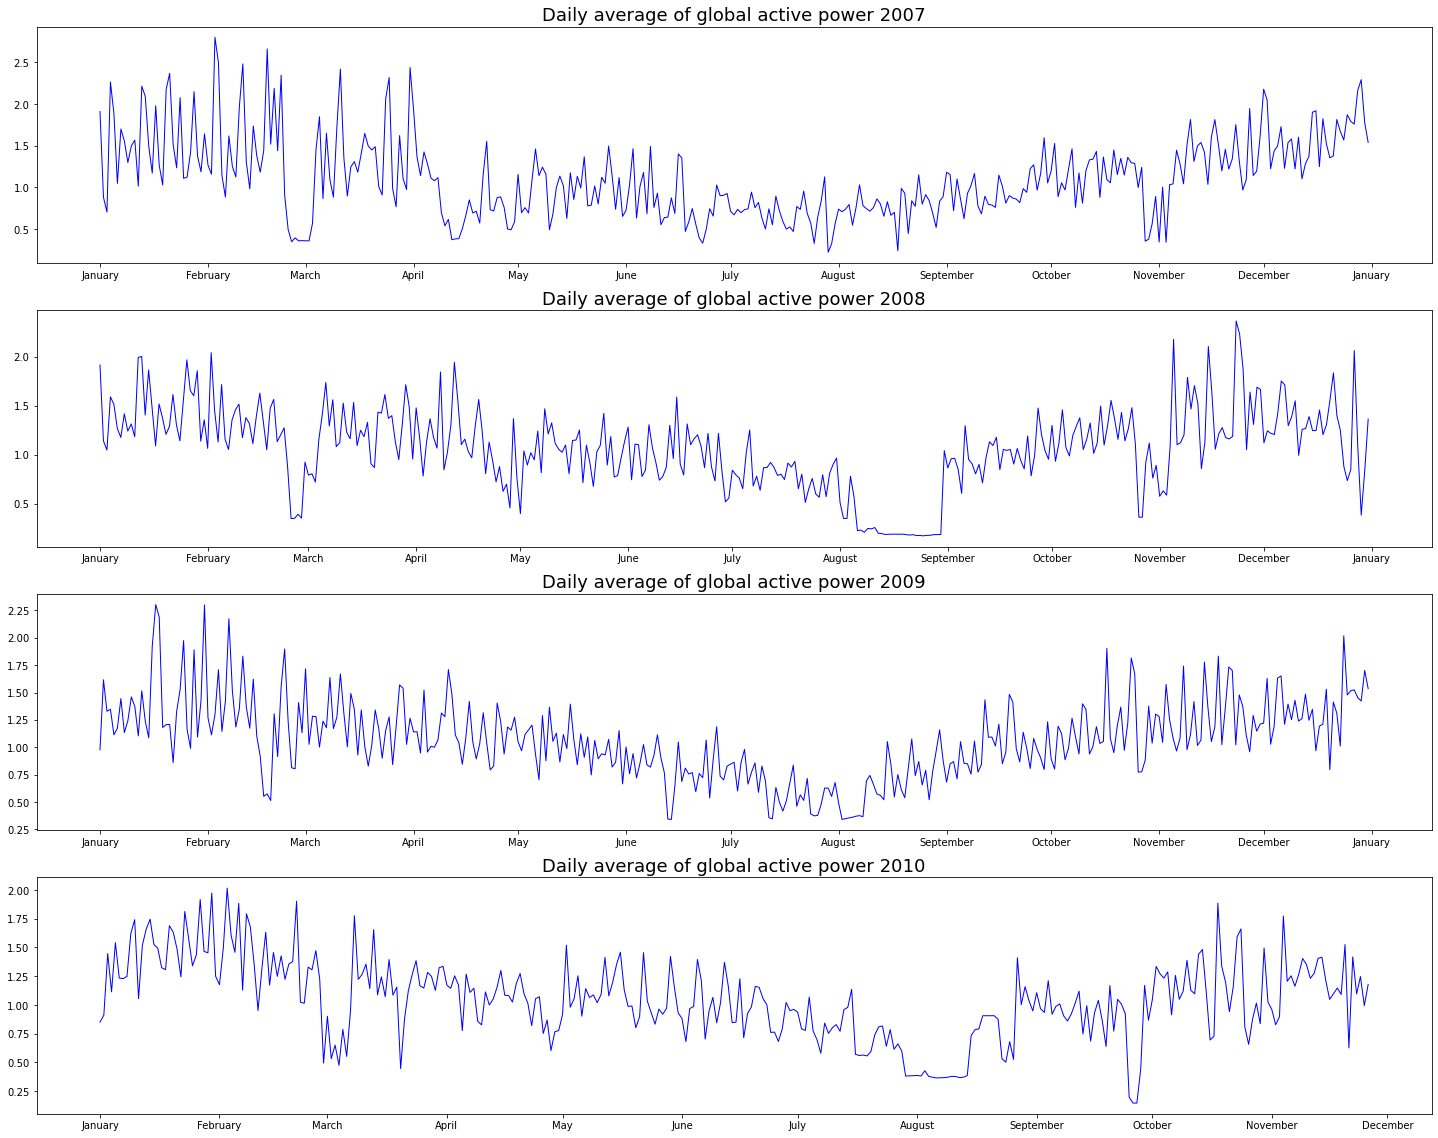

In [381]:
years=[2007,2008,2009,2010]
dtFmt = mdates.DateFormatter('%B') # Definir formato de fecha
plt.figure(figsize=(25,20))
for i in range(0,4):
    plt.subplot(4,1,i+1)
    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    #plt.ylim((0,11))
    plt.plot(promedio_diario[promedio_diario.index.year==years[i]]['Global_active_power'], linewidth=1, color='blue')
    plt.title("Daily average of global active power "+str(years[i]), fontsize=18); 

No se distinguen cláramente épocas que concentren mínimos, por lo que se procede a extraerlos numéricamente.

In [382]:
# Un dataframe para cada año estudiado
avg_2007=promedio_diario[promedio_diario.index.year==years[0]]
avg_2008=promedio_diario[promedio_diario.index.year==years[1]]
avg_2009=promedio_diario[promedio_diario.index.year==years[2]]
avg_2010=promedio_diario[promedio_diario.index.year==years[3]]


In [383]:
# Se diseña una función que entregue el mínimo y su fecha
def min_df(df):
    """ Entrega el mínimo de un dataframe y la fecha en que ocurre

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe de global active power

    Returns
    -------
    tuple
        El primer valor es la fecha y el segundo el valor del mínimos
    """
    df_minimo=df.loc[df.idxmin()]
    min_gap=df_minimo['Global_active_power']
    return min_gap.index, min_gap[0]

In [384]:
# Se calculan los minimos y su época
t_2007, min_2007 = min_df(avg_2007)
t_2008, min_2008 = min_df(avg_2008)
t_2009, min_2009 = min_df(avg_2009)
t_2010, min_2010 = min_df(avg_2010)

In [385]:
# Generación de dataframe con los resultados
mins_array = np.array([[min_2007],[min_2008],[min_2009],[min_2010]])
df_mins = pd.DataFrame(mins_array, columns = ['Mínimos anuales'], index = [t_2007[0], t_2008[0],t_2009[0],t_2010[0]])
df_mins

,Mínimos anuales
2007-07-29,0.222997
2008-08-25,0.173818
2009-06-14,0.340000
2010-09-26,0.146000


#### Curva suavizada

Contrastando los mínimos puntuales con los gráficos, se puede observar que estos no necesariamente concuerdan con las tendencias. Frente a esto, se suaviza la curva y se observa la época en que ocurre el mínimo de cada año. Con este fin, se utiliza filtro de Kalman porque entrega buenos resultados y no tiene tantos requisitos.



In [386]:
# Se hace un diccionario con los datos de promedios diarios convertidos a arrays.
avgs_dict={}
avgs_dict[2007]=avg_2007[['Global_active_power']].to_numpy()
avgs_dict[2008]=avg_2008[['Global_active_power']].to_numpy()
avgs_dict[2009]=avg_2009[['Global_active_power']].to_numpy()
avgs_dict[2010]=avg_2010[['Global_active_power']].to_numpy()

In [387]:
# Se genera un smoother para cada año, para luego extraer el intervalo y la curva suavizada. 
smoothers=[]
lows=[]
ups=[]
dates=[avg_2007.index,avg_2008.index,avg_2009.index,avg_2010.index]
for i in years:
    smoother = KalmanSmoother(component='level_season',component_noise={'level':0.1,'season':0.1},n_seasons=12)
    smoother.smooth(avgs_dict[i])

    # se generan los intervalos.
    low, up = smoother.get_intervals('kalman_interval')
    smoothers.append(smoother)
    lows.append(low)
    ups.append(up)

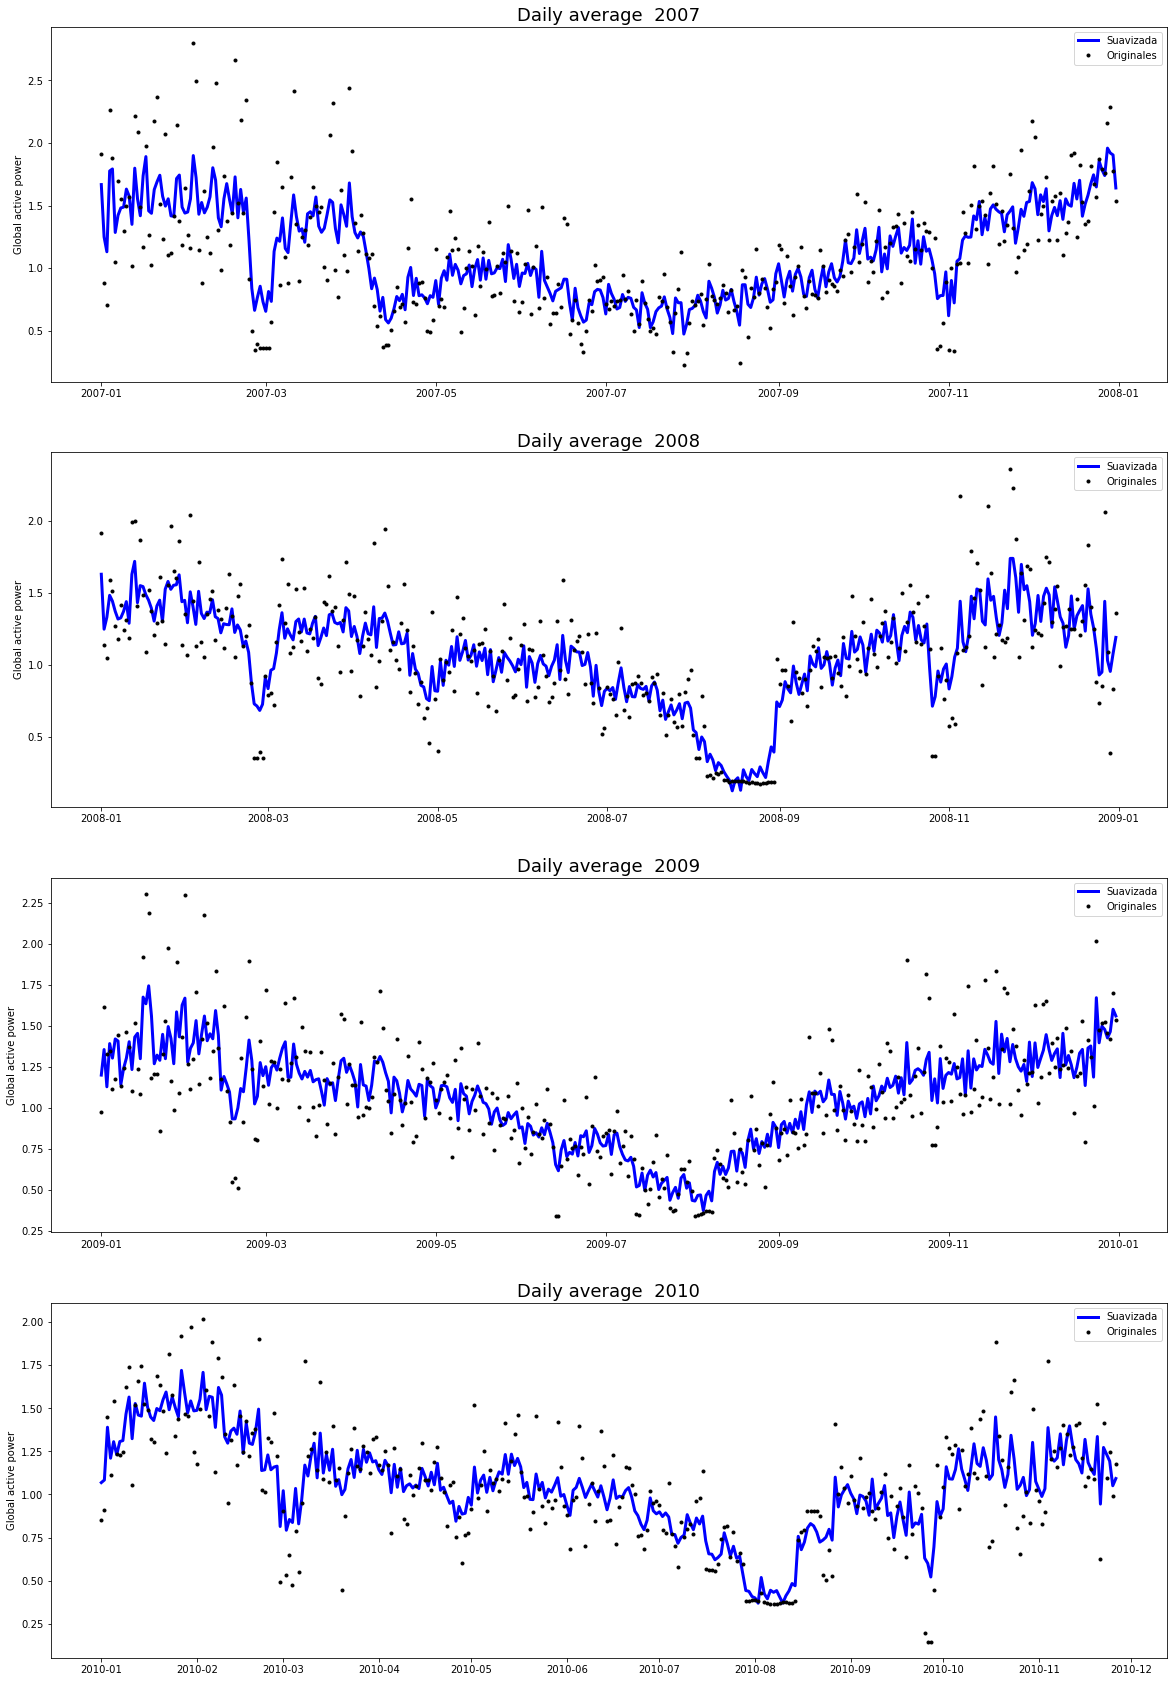

In [388]:
# Gráficos para los 4 años por separado
plt.figure(figsize=(20,30))
for i in range(4):
    
    plt.subplot(4,1,i+1)
    plt.plot(dates[i],smoothers[i].smooth_data[0], linewidth=3, color='blue')
    plt.plot(dates[i],smoothers[i].data[0], '.k')
    plt.ylabel('Global active power')
    plt.title(f"Daily average  {i+2007}", fontsize=18)
    #plt.fill_between(dates[i], lows[i][0], ups[i][0], alpha=0.3)
    plt.legend(['Suavizada','Originales'],loc="best")

In [389]:
# Generación de un dataframe con los resultados
mins=[]
indexes=[]
for i in range(4):
    mins.append([smoothers[i].smooth_data[0].min()])
    indexes.append(dates[i][np.argmin(smoothers[i].smooth_data[0])].date())
mins_array = np.array(mins)
df_mins = pd.DataFrame(mins_array, columns = ['Mínimos anuales'], index = indexes)
df_mins

,Mínimos anuales
2007-07-29,0.473472
2008-08-15,0.123970
2009-08-05,0.374534
2010-08-02,0.369328


De los resultados obtenidos se distingue que la época que se busca se concentra aproximadamente en la primera mitad de Agosto. 

### **5. Implementar una función que encuentre dicho mínimo para cada año.**

### Filtrar ruido
La estrategia para filtrar el ruido sin alterar mucho los datos originales, es utilizar el intervalo entregado por el filtro de Kalman. A continuación, se presenta de manera gráfica que hay puntos que salen del intervalo.

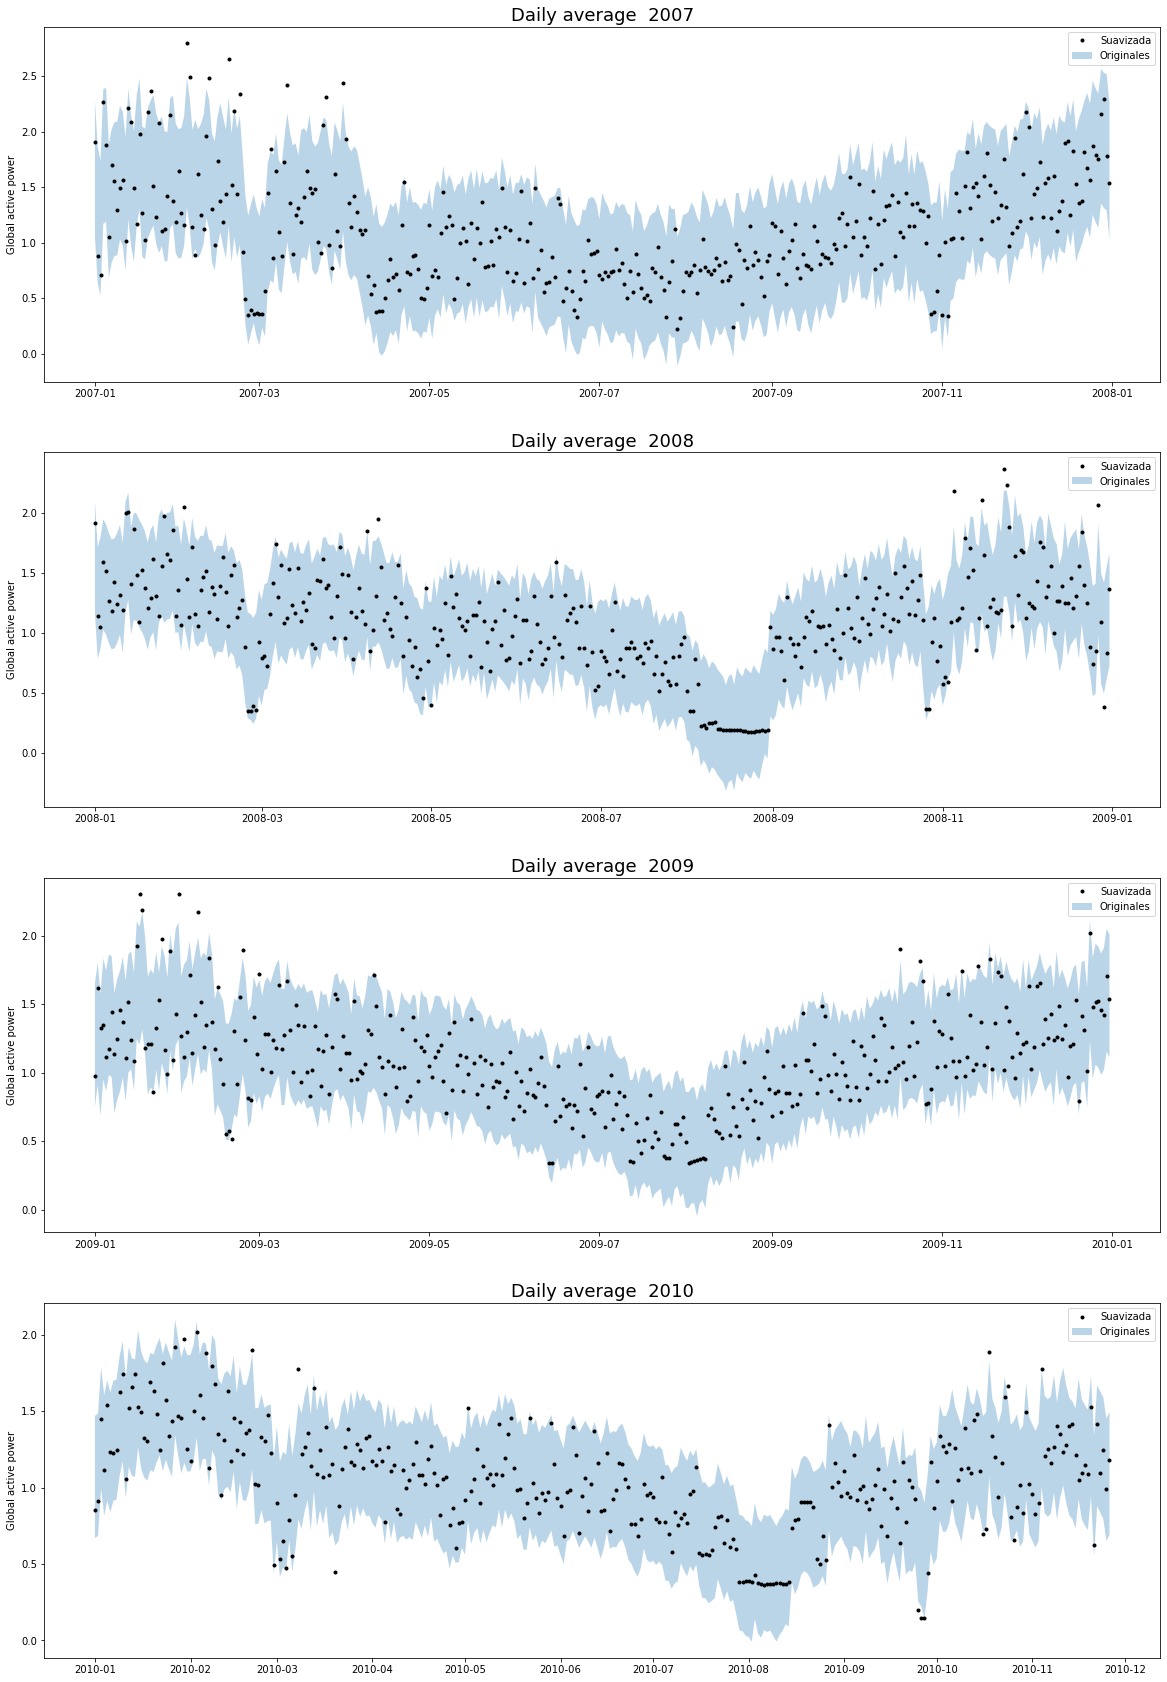

In [390]:
plt.figure(figsize=(20,30))
for i in range(4):    
    plt.subplot(4,1,i+1)
    plt.plot(dates[i],smoothers[i].data[0], '.k')
    plt.ylabel('Global active power')
    plt.title(f"Daily average  {i+2007}", fontsize=18)
    plt.fill_between(dates[i], lows[i][0], ups[i][0], alpha=0.3)
    plt.legend(['Suavizada','Originales'],loc="best")

In [391]:
# Sacar el ruido de los valores
def filter_noise(avg_array,lows_array):
    """ Saca los valores del array que exceden del umbral entregado

    Parameters
    ----------
    avg_array : array
        Array con promedios diarios

    lows_array : array
        Array con umbrales inferiores

    Returns
    -------
    list
        Idéntico al array de entrada, pero sin los valores que exceden al umbral.
    """
    filtered_values=[]
    for i in range(0,len(avg_array)):
        if avg_array[i][0]<= lows_array[0][i]:
           pass
        else:
           filtered_values.append(avg_array[i][0])
    return filtered_values

       

In [392]:
# Encuentra la fecha y valor del mínimo
def min_founder(avg_array,year_dates,lows_array):
    """ Entrega los mínimos de una serie de tiempo, ignorando el ruido.

    Parameters
    ----------
    avg_array : array
        Array con promedios diarios

    year_dates: pandas.DatetimeIndex
        Array con las fechas de un año

    lows_array : array
        Array con umbrales inferiores

    Returns
    -------
    tuple
        Fecha y valor mínimo
    """
    min_value=min(filter_noise(avg_array,lows_array))
    min_date=year_dates[np.where(avg_array == [min_value])[0][0]]
    return min_date.date(), min_value    


In [393]:
# Calcular para cada año
cleaned_mins=[]
for i in range(4):
    cleaned_mins.append(min_founder(avgs_dict[years[i]],dates[i],lows[i]))

In [394]:
mins=[]
indexes=[]
for i in range(4):
    mins.append([cleaned_mins[i][1],cleaned_mins[i][0]])
    indexes.append(cleaned_mins[i][0].year)
mins_array = np.array(mins)
df_mins = pd.DataFrame(mins_array, columns = ['Mínimos anuales','Fecha'], index = indexes)
df_mins

,Mínimos anuales,Fecha
2007,0.222997,2007-07-29
2008,0.173818,2008-08-25
2009,0.34,2009-06-14
2010,0.146,2010-09-26


### **6. Predicción para el 2011 del promedio diario** 

Para la predicción se utilizara Prophet, una librería open-source para el forecasting de series de tiempo de una sola variable. Se escoge por su facilidad de implementación y porque tiene buen rendimiento cuando los datos poseen componentes estacionales.

In [395]:
def clean_data(avg_array,lows_array,ups_array):
    """ Entrega un arreglo, cambiando los elementos de ruido por NaNs.

    Parameters
    ----------
    avg_array : array
        Array con promedios diarios

    lows_array : array
        Array con umbrales inferiores

    ups_array : array
        Array con umbrales superiores        

    Returns
    -------
    list
        Lista con los datos filtrados
    """
    new_data=[]
    for i in range(0,len(avg_array)):
        if avg_array[i][0]<= lows_array[0][i] or avg_array[i][0]>= ups_array[0][i]:
           new_data.append(np.NAN)
        else:
           new_data.append(avg_array[i][0])
    return new_data

In [396]:
# Preparación de un array con los datos limpios
cleaned_data=[]
for i in range(4):
    cleaned_data+=clean_data(avgs_dict[years[i]],lows[i],ups[i])
    cleaned_data_array=np.vstack(cleaned_data)

In [397]:
# Transformación a dataframe
df_cleaned = pd.DataFrame(cleaned_data_array, columns = ['Global_active_power'], index = promedio_diario.index)
df_cleaned.fillna(axis=0,method='ffill',inplace=True)
df_cleaned.head()


,Global_active_power
2007-01-01,1.909031
2007-01-02,0.881414
2007-01-03,0.704204
2007-01-04,2.263481
2007-01-05,1.884281


Se hace un split de entrenamiento para ver si la herramienta ocupada se ajusta a los datos de trabajo.

In [398]:
# Train ocupa los datos previos al 2010 y test postreriores
df_train, df_test = df_cleaned[df_cleaned.index.year<2010], df_cleaned[df_cleaned.index.year>=2010]
# Número de elementos por dataset
print('Train:\t', len(df_train))
print('Test:\t', len(df_test))


Train:	 1096
Test:	 330


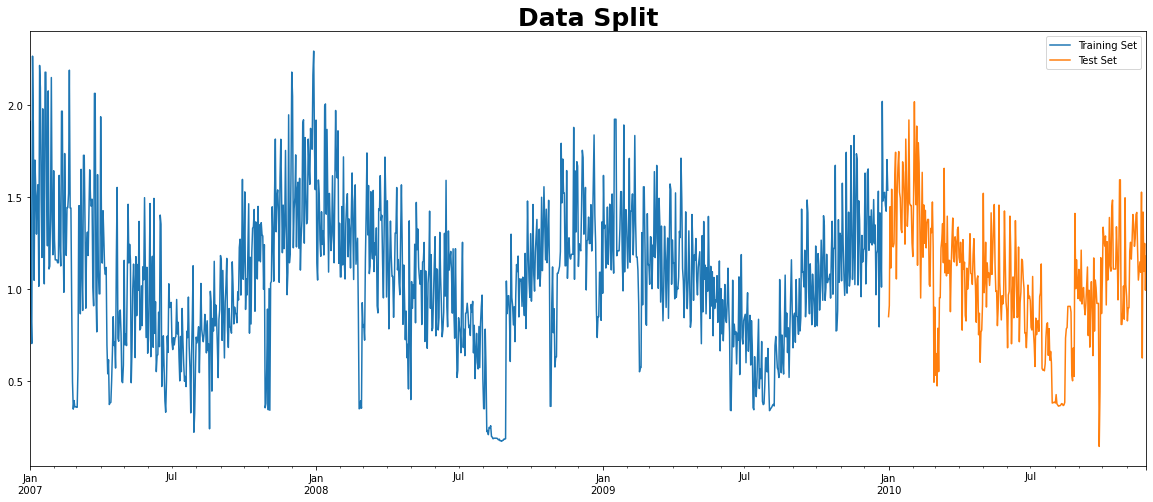

In [399]:
# Se grafica el split de entrenamiento
plt.figure(figsize=(20,8))
df_train['Global_active_power'].plot(label='Training Set')
df_test['Global_active_power'].plot(label='Test Set')
plt.title('Data Split', weight='bold', fontsize=25)
plt.legend()
plt.show()

### **6. Gráfico de las predicciones** 
Se preparan los datasets para aplicar el modelo.

In [400]:
def index_to_column(data):
    """ Mueve indice de un dataframe a una columna.

    Parameters
    ----------
    pandas.DataFrame : array
        Array con promedios diarios     

    Returns
    -------
    pandas.DataFrame
        Dataframe con una columna de fecha y una de Global active power
    """    
    data['Datetime'] = pd.to_datetime(data.index)
    data = data.sort_values('Datetime')
    data = data.reset_index()
    data = data.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
    return data[['ds','y']]

In [401]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

c:\Users\al_va\miniconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\al_va\miniconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [402]:
# Ajuste del modelo
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:56 - cmdstanpy - INFO - Chain [1] done processing


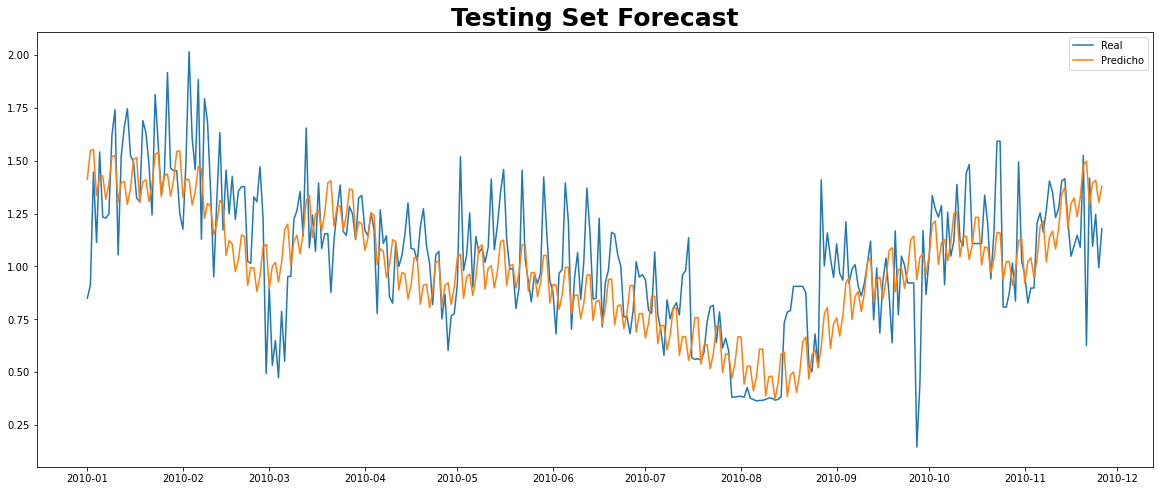

In [403]:
# Gráfico de testeo de predicción
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)
plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Real')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicho')
plt.title('Test Forecasting', weight='bold', fontsize=40)
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [404]:
new_df = index_to_column(df_cleaned)

In [405]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 365 dias hacia adelante
future_dates = prophet_model2.make_future_dataframe(periods=365, freq='D')
prophet_pred2 = prophet_model2.predict(future_dates)

17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1800x1224 with 0 Axes>

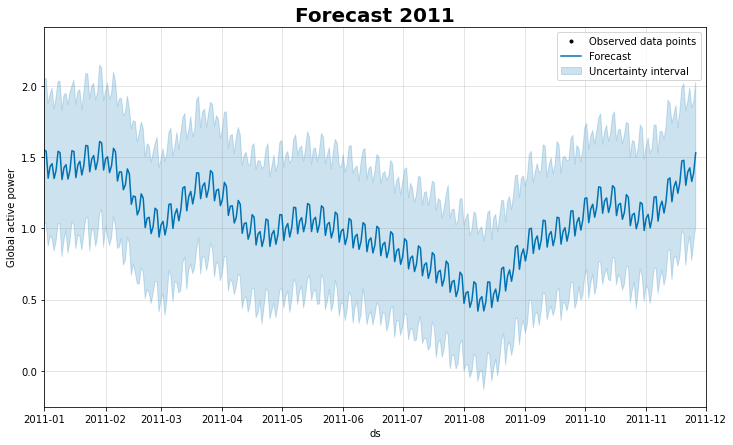

In [406]:
plt.figure(figsize=(25,17))
fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2011-01', '2011-12']))
plt.ylabel('Global active power')
plt.legend()
plt.title('Forecast 2011', weight='bold', fontsize=20)
plt.show()

### **7. Componentes de frecuencia más relevantes** 

Se entiende por "componentes principales de frecuencia" a las frecuencias naturales de resonancia que aparecen luego de hacer transformada de Fourier y analizar la densidad espectral de potencia. 

In [407]:
# Variables objetivo predichas
x=prophet_pred2[['ds']]
y=prophet_pred2[['yhat']]

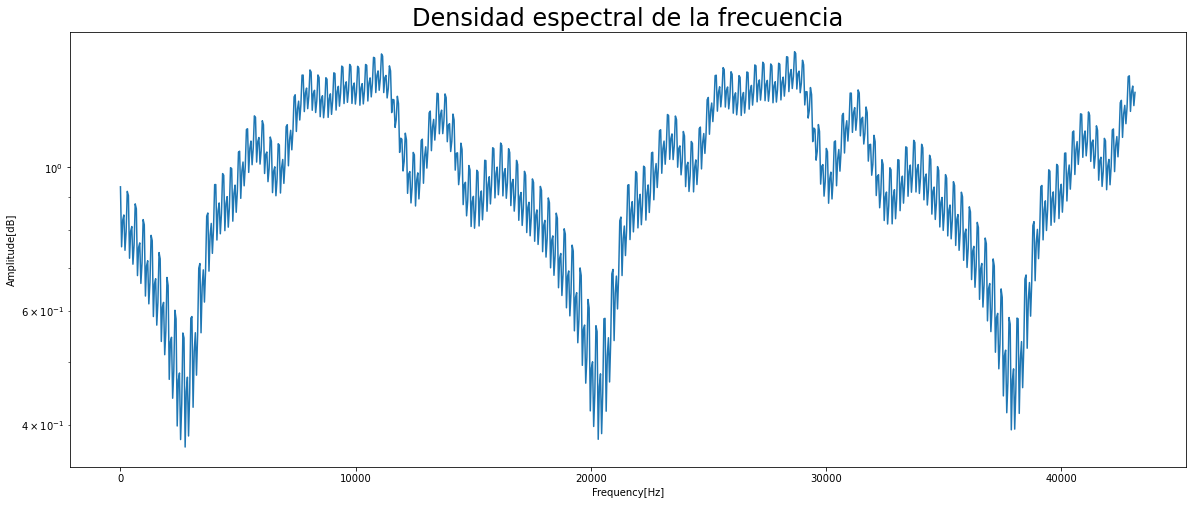

In [408]:
# Calculo de transformada de Fourier y densidad espectral

N = 1 * len(y) # Número de muestras
frame_rate=24*60*60 # Frecuencia de muestreo en segundos
yf = fft(y) # Transformada de fourier
xf = fftfreq(N, 1 / frame_rate) 
xf = fftshift(xf) # Se ajusta la frecuencia cero al centro del gráfico
nspectrum=np.abs(yf)/np.abs(yf).mean() # Densidad espectral de potencia

idx0=np.where(xf==xf[xf>=0][0])[0][0] # Indice donde ocurre el 0 en el eje horizontal 

# Gráfico de frecuencias
plt.figure(figsize=(20,8))
plt.title('Densidad espectral de la frecuencia',fontsize=24)
plt.xlabel('Frequency[Hz]')
plt.ylabel('Amplitude[dB]')
#plt.semilogy(xf, nspectrum) 
plt.semilogy(xf[idx0:-1], nspectrum[idx0:-1])
plt.show()

Se observa en el gráfico al menos dos máximos,  por lo que se desprende que hay extraer dos frecuencias naturales.

In [409]:
density=nspectrum.reshape(len(nspectrum))
idx=np.argsort(density)[-4:-1] # 4 indices de valores máximos, por la propiedad de espejo
print('Frecuencias:')
for n,i in enumerate(idx):
    if xf[i]>0:
       print(xf[i],'Hz')


Frecuencias:
28703.5175879397 Hz


Adicionalmente, se analizan los componentes de estacionalidad, tendencia y residuo para el año 2011.

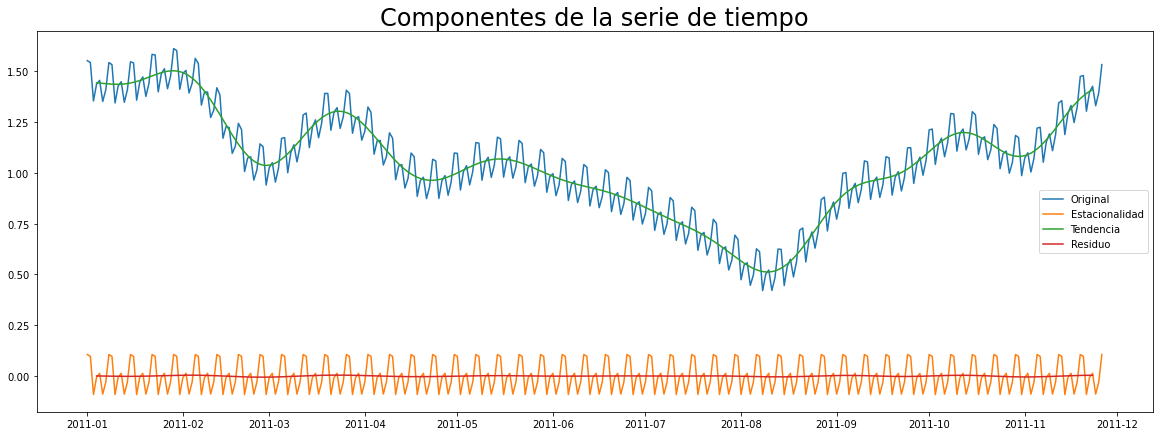

In [410]:

pred_2011=prophet_pred2[['ds','yhat']]
pred_2011.set_index('ds',inplace=True)
pred_2011=pred_2011[pred_2011.index.year>2010]
decomposition = seasonal_decompose(pred_2011) 
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(pred_2011, label='Original')
ax.plot(seasonal, label='Estacionalidad')
ax.plot(trend, label='Tendencia')
ax.plot(residual, label='Residuo')
ax.legend(loc='best')
ax.set_title('Componentes de la serie de tiempo',fontsize=24)
plt.show()